In [1]:
# Importer les bibliothèques nécessaires
import os
import sys
import numpy as np
import mrcnn.model as modellib
import mrcnn.model as MaskRCNN
from mrcnn.config import Config
from mrcnn import utils

import json
import os
from pycocotools.coco import COCO


/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or 

In [2]:
class CustomConfig(Config):
    NAME = "custom_model"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # 1 Background + 1 classe pour ton objet
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.85
    LEARNING_RATE = 1e-3


In [3]:
import json
import numpy as np
from PIL import Image, ImageDraw
import os
from mrcnn import utils

class CustomDataset(utils.Dataset):
    def load_custom(self, dataset_dir):
        # Ajouter les classes (par exemple, une classe nommée "sword")
        self.add_class("dataset", 1, "sword")  # Remplace "sword" par le nom réel de ta classe

        # Parcourir les fichiers JSON pour associer chaque image à ses annotations
        for filename in os.listdir(dataset_dir):
            if filename.endswith(".json"):
                json_path = os.path.join(dataset_dir, filename)
                
                # Charger le fichier JSON
                with open(json_path) as f:
                    data = json.load(f)

                # Obtenir le chemin de l'image correspondant
                image_filename = data['imagePath'].replace("\\", "/").split("/")[-1]
                image_path = os.path.join(dataset_dir, image_filename)

                # Vérifier si le fichier image existe
                if not os.path.exists(image_path):
                    print("Image non trouvée pour {}".format(filename))
                    continue
                
                # Ajouter l'image au dataset
                image_id = os.path.splitext(filename)[0]
                self.add_image(
                    "dataset",
                    image_id=image_id,
                    path=image_path,
                    width=data['imageWidth'],
                    height=data['imageHeight'],
                    polygons=data['shapes']  # Liste des polygones pour chaque objet
                )

    def load_mask(self, image_id):
        # Récupérer les informations de l'image
        image_info = self.image_info[image_id]
        polygons = image_info['polygons']

        # Créer un masque vide (hauteur, largeur, nombre de polygones)
        mask = np.zeros([image_info["height"], image_info["width"], len(polygons)], dtype=np.uint8)

        # Remplir le masque pour chaque polygone
        for i, shape in enumerate(polygons):
            # Convertir les points en tuples (x, y)
            polygon_points = [(int(x), int(y)) for x, y in shape['points']]
            img = Image.new('L', (image_info["width"], image_info["height"]), 0)
            ImageDraw.Draw(img).polygon(polygon_points, outline=1, fill=1)
            mask[:, :, i] = np.array(img)

        # Retourner les masques et les IDs de classe
        class_ids = np.array([1] * len(polygons), dtype=np.int32)  # Ajuste si tu as plusieurs classes
        return mask, class_ids



In [4]:
dataset_train = CustomDataset()
dataset_train.load_custom("/host/my_dataset_train")  # Plus besoin du paramètre "train"
dataset_train.prepare()

dataset_val = CustomDataset()
dataset_val.load_custom("/host/my_dataset_val")  # Plus besoin du paramètre "val"
dataset_val.prepare()


In [5]:

# Créer la configuration
config = CustomConfig()

# Initialiser le modèle
model = modellib.MaskRCNN(mode="training", config=config, model_dir="logs/")

# Charger les poids du model pré-entraîné
trained_model_path = "/host/my_models/mask_rcnn_custom_model_0032.h5"
model.load_weights(trained_model_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

# Configurer l'optimiseur comme ADAM
from keras.optimizers import Adam
model.keras_model.optimizer = Adam(lr=config.LEARNING_RATE)


In [6]:
from imgaug import augmenters as iaa

augmentation = iaa.Sometimes(0.5, [
    iaa.Fliplr(0.5),  # Flip horizontal
    iaa.Affine(rotate=(-20, 20)),  # Rotation
    iaa.Multiply((0.8, 1.2)),  # Changement de luminosité
])

In [7]:
model.train(
    dataset_train,
    dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=10,
    layers="heads",
    augmentation=augmentation
)


Starting at epoch 0. LR=0.001

Checkpoint Path: logs/custom_model20241124T2259/mask_rcnn_custom_model_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4      

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
 99/100 [============================>.] - ETA: 14s - loss: 1.6249 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.6586 - mrcnn_class_loss: 0.1254 - mrcnn_bbox_loss: 0.5037 - mrcnn_mask_loss: 0.3160

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 1500s 15s/step - loss: 1.6202 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.6528 - mrcnn_class_loss: 0.1275 - mrcnn_bbox_loss: 0.5034 - mrcnn_mask_loss: 0.3153 - val_loss: 1.1921 - val_rpn_class_loss: 0.0119 - val_rpn_bbox_loss: 0.5240 - val_mrcnn_class_loss: 0.0812 - val_mrcnn_bbox_loss: 0.3819 - val_mrcnn_mask_loss: 0.1931
Epoch 2/10
100/100 [==============================] - 1476s 15s/step - loss: 2.1131 - rpn_class_loss: 0.1741 - rpn_bbox_loss: 1.2606 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.4016 - mrcnn_mask_loss: 0.2045 - val_loss: 1.0437 - val_rpn_class_loss: 0.0112 - val_rpn_bbox_loss: 0.4175 - val_mrcnn_class_loss: 0.0795 - val_mrcnn_bbox_loss: 0.3676 - val_mrcnn_mask_loss: 0.1680
Epoch 3/10
100/100 [==============================] - 1474s 15s/step - loss: 1.0779 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.5073 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.3058 - mrcnn_mask_loss: 0.1741 - val_loss: 1.1988 - val_rpn_class_loss: 

model.train(
    dataset_train,                  # Dataset d'entraînement
    dataset_val,                    # Dataset de validation
    learning_rate=config.LEARNING_RATE,
    epochs=10,
    layers='heads',                  # Spécifiez les couches à entraîner
    augmentation=augmentation,
    callbacks=[checkpoint]
)

Exemples du Dataset d'Entraînement


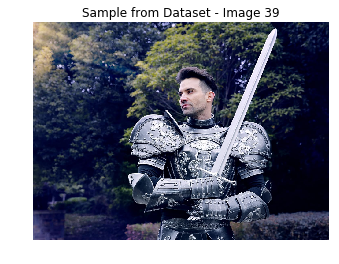

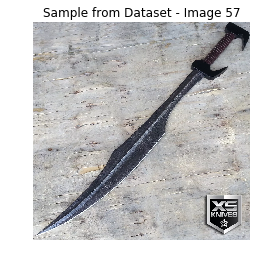

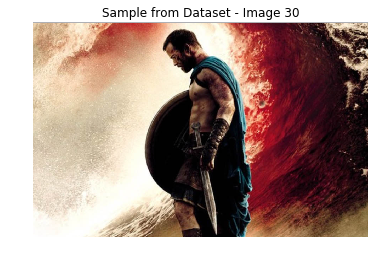

Exemples du Dataset de Validation


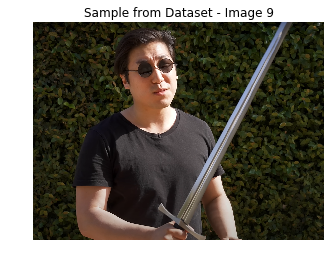

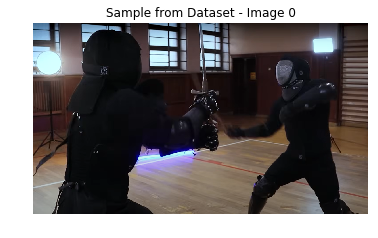

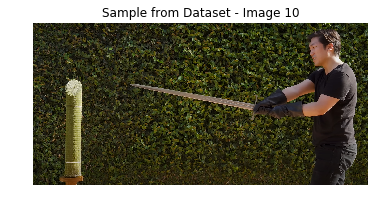

In [8]:
import matplotlib.pyplot as plt
import random

def display_sample(dataset, count=3):
    """Affiche un échantillon d'images du dataset."""
    for i in range(count):
        image_id = random.choice(dataset.image_ids)
        image = dataset.load_image(image_id)
        plt.imshow(image)
        plt.title("Sample from Dataset - Image {}".format(image_id))
        plt.axis("off")
        plt.show()

# Affichez 3 images du dataset d'entraînement et de validation
print("Exemples du Dataset d'Entraînement")
display_sample(dataset_train)
print("Exemples du Dataset de Validation")
display_sample(dataset_val)
